# Cyber Threat Detection
This project implements a deep learning model to classify network events as malicious or benign using labeled datasets. It preprocesses data, builds a multi-layer neural network, and trains it with early stopping to optimize performance. The project evaluates the model on test data, providing detailed metrics and visualizations of the training process, and saves the trained model for future use in cybersecurity applications.
this is the link of dataset: [link text](https://www.kaggle.com/datasets/katehighnam/beth-dataset)

# Upload Files
This snippet allows you to upload files directly from your local system to the Colab environment. The files.upload() function opens a file chooser dialog, and the uploaded files will be available in the current working directory.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving archive (3).zip to archive (3).zip


In [2]:
!unzip archive.zip -d /content/Data

Archive:  archive.zip
  inflating: /content/Data/labelled_2021may-ip-10-100-1-105-dns.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-105.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-186-dns.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-186.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-26-dns.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-26.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-4-dns.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-4.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-95-dns.csv  
  inflating: /content/Data/labelled_2021may-ip-10-100-1-95.csv  
  inflating: /content/Data/labelled_2021may-ubuntu-dns.csv  
  inflating: /content/Data/labelled_2021may-ubuntu.csv  
  inflating: /content/Data/labelled_testing_data.csv  
  inflating: /content/Data/labelled_training_data.csv  
  inflating: /content/Data/labelled_validation_data.csv  


# Import Libraries


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Load the Labeled Datasets

In [4]:
# Load the labeled training and testing datasets
dataset_path_train = "/content/Data/labelled_training_data.csv"
dataset_path_test = "/content/Data/labelled_testing_data.csv"
data_train = pd.read_csv(dataset_path_train)
data_test = pd.read_csv(dataset_path_test)

# Step 2: Exploratory Data Analysis and Preprocessing

In [5]:
# Print an overview of the datasets
print("Training Dataset Overview:\n")
data_train.head()


Training Dataset Overview:



,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,1809.495787,381,7337,1,100,4026532231,close,ip-10-100-1-120,157,prctl,"[140662171848350, 11649800180280676]",5,0,"[{'name': 'option', 'type': 'int', 'value': 'P...",1,0
1,1809.495832,381,7337,1,100,4026532231,close,ip-10-100-1-120,3,close,[140662171777451],1,0,"[{'name': 'fd', 'type': 'int', 'value': 19}]",1,0
2,1809.495921,381,7337,1,100,4026532231,close,ip-10-100-1-120,1010,sched_process_exit,[],0,0,[],1,0
3,1894.139651,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,21,access,[],2,-2,"[{'name': 'pathname', 'type': 'const char*', '...",1,0
4,1894.142127,7347,7347,7341,0,4026531840,sh,ip-10-100-1-120,1005,security_file_open,"[139778263990104, 139778263906698]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",1,0


In [6]:
# Print an overview of the datasets
print("\nTesting Dataset Overview:\n")
data_test.head()


Testing Dataset Overview:



,timestamp,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
0,129.050634,382,382,1,101,4026532232,systemd-resolve,ip-10-100-1-217,41,socket,"[140159195621643, 140159192455417, 94656731598...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
1,129.051238,379,379,1,100,4026532231,systemd-network,ip-10-100-1-217,41,socket,"[139853228042507, 93935071185801, 93935080775184]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
2,129.051434,1,1,0,0,4026531840,systemd,ip-10-100-1-217,1005,security_file_open,"[140362867191588, 8103505641674583858]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
3,129.051481,1,1,0,0,4026531840,systemd,ip-10-100-1-217,257,openat,[],4,17,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
4,129.051522,1,1,0,0,4026531840,systemd,ip-10-100-1-217,5,fstat,[140362867189385],2,0,"[{'name': 'fd', 'type': 'int', 'value': 17}, {...",0,0


In [7]:
# Handle missing values, if any
data_train = data_train.dropna()
data_test = data_test.dropna()

In [8]:
# Encode labels using 'sus' or 'evil' columns
# Malicious = 1 if 'sus' or 'evil' is 1, else Benign = 0
data_train['label'] = ((data_train['sus'] == 1) | (data_train['evil'] == 1)).astype(int)
data_test['label'] = ((data_test['sus'] == 1) | (data_test['evil'] == 1)).astype(int)

In [9]:
# Split features and labels
X_train = data_train.drop(['label', 'sus', 'evil'], axis=1)
y_train = data_train['label']
X_test = data_test.drop(['label', 'sus', 'evil'], axis=1)
y_test = data_test['label']

In [10]:
# Identify and select only numeric columns
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train = X_train[numeric_columns]
X_test = X_test[numeric_columns]

# Normalize numeric columns
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())


# Step 3: Build and Compile the Deep Learning Model

In [11]:
# Define the model architecture
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model

In [13]:
# Setup early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.9995 - loss: 0.0059 - val_accuracy: 0.7762 - val_loss: 0.2093
Epoch 2/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9996 - loss: 8.6123e-04 - val_accuracy: 0.9977 - val_loss: 0.0826
Epoch 3/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.9996 - loss: 8.7287e-04 - val_accuracy: 0.9935 - val_loss: 0.1792
Epoch 4/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.9996 - loss: 8.2311e-04 - val_accuracy: 0.9979 - val_loss: 0.1510
Epoch 5/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - accuracy: 0.9995 - loss: 8.7923e-04 - val_accuracy: 0.9996 - val_loss: 0.1477
Epoch 6/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9996 - loss: 9.0892e-04 - val_accuracy: 0.9974 - val_loss: 0.1676
Epoch 7/50
19079/19079 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9995 - loss: 8.9479e-04 - val_accuracy: 0.9974 - val_loss: 0.2018


# Step 5: Evaluate the Model

In [14]:
# Make predictions on the test dataset
predictions = (model.predict(X_test) > 0.5).astype("int32")

5906/5906 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [17]:
# Print classification metrics
print("\nClassification Report:\n", classification_report(y_test, predictions))
print("\nAccuracy Score:", accuracy_score(y_test, predictions))


Classification Report:
               precision    recall  f1-score   support

           0       0.09      1.00      0.17     17508
           1       1.00      0.00      0.00    171459

    accuracy                           0.09    188967
   macro avg       0.55      0.50      0.09    188967
weighted avg       0.92      0.09      0.02    188967


Accuracy Score: 0.09355601771737923


# Step 6: Save the Trained Model

In [18]:
# Save the model to a file
model.save("cyber_threat_detection_model.h5")

# Step 7: Visualize Training History

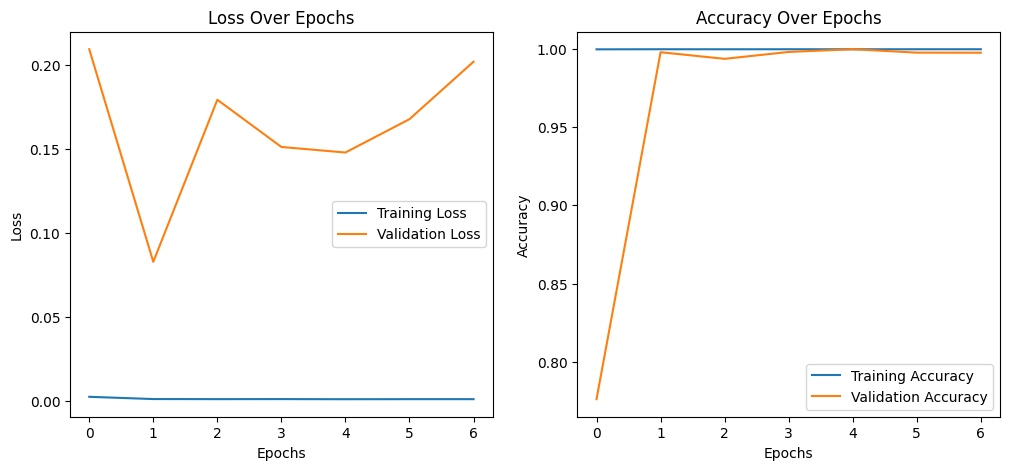

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
